In [1]:
#import required packages and classes
import numpy as np
import os
import cv2
import timeit
import random
import hashlib
import math
import matplotlib.pyplot as plt
from SCD import *
from math import log10, sqrt
from skimage.metrics import structural_similarity as ssim
import warnings
warnings.filterwarnings('ignore')

In [2]:
#defining global variables
global filename, w, h, channel
encryption_done = 0

In [3]:
#SCD optimization function
def getSCDOptimization():
    x_min = np.zeros(80, dtype=int)  # All zeros
    x_max = np.full(80, 255, dtype=int)  # All 255s
    x_initial_scd = 0.5 #chi_square_stat  # Given initial value which is chi square value
    accuracy = 1  # Desired accuracy for stopping condition
    m = 80  # Number of coordinates
    max_steps = 3 * m  # Maximum number of steps
    # Run Segmented Coordinate Descent with floored values
    x_optimized, y_optimized = SCD(x_min, x_max, x_initial_scd, accuracy, max_steps)
    return x_optimized, y_optimized

In [4]:
#generate FIPWLCM K one-to-one correspondence with the chaotic sequences
def getFIPWLCM(k, length_of_k):
    start = 0
    end = 1
    c = 0
    v1 = 0
    v2 = 0
    while start < length_of_k - 1:
        v1 += k[start] ^ k[end]
        start = end
        end += 1
        if end == 32:
            end = 0
        v2 += k[start] ^ k[end]
        start += 1
        end += 1
    c = (v1 % 127) + (v2 % 128)
    ki = []
    for i in range(0, length_of_k):
        ki.append((k[i] + c) % 256)
    return ki

In [5]:
#propose encryption function
def proposeEncryption(fname):
    global filename, w, h, channel, encryption_done
    filename = fname
    encryption_done = 1
    img = cv2.imread(filename) #read image
    w, h, channel = img.shape
    I0 = img.ravel() #3 dimensional image to one dimension
    l = len(I0)#get length of one dimension vector
    for i in range(0, 10): #add 10 random pixels to form NI0
        random_pixels = random.randint(np.min(I0), np.max(I0))
        if i == 0:
            NI0 = np.append(I0, random_pixels)
        else:
            NI0 = np.append(NI0, random_pixels)
    x_optimized, y_optimized = getSCDOptimization() #get SCD optimization to convert high dimensional optimization to low dimension optimization
    NI0 = NI0.tobytes()
    #execute SEA and FI-PWLCM sequence generation and 
    k = hashlib.sha256(NI0).digest() #get 32 bytes hash value
    temp = []
    for i in range(len(k)):
        temp.append(k[i])
    k = np.asarray(temp)    
    k = np.minimum(k, x_optimized)#convert K high dimension to SCD low dimension
    length_of_k = len(k)
    ki = getFIPWLCM(k, length_of_k)#get SEA and FIPWLCM sequences which can be used to generate K key value
    K = []
    i=0
    start = 1
    while i < l:
        A = ki[1:start] #get A and B values
        B = ki[start+1:length_of_k]
        i += 1
        C = 0
        start += 1
        if start == 32:
            start = 1
        for j in range(0, (min(len(A), len(B)))):#apply XOR or A and B values to generate C sequences
            C += A[j] ^ B[j]
        K.append(C) #add C sequences to K to form image encryption key 
    encrypted = []
    for i in range(0, len(I0)):
        encrypted.append(I0[i] ^ K[i])
    encrypted = np.asarray(encrypted)
    encrypted = np.reshape(encrypted, (w, h, channel))
    np.save("EncryptedImages/"+os.path.basename(filename), encrypted)
    keys = [K, encrypted, w, h, channel]
    keys = np.asarray(keys)
    np.save("keys/"+os.path.basename(filename), keys)
    #encrypted = np.load("EncryptedImages/"+os.path.basename(filename)+".npy")
    figure, axis = plt.subplots(nrows=1, ncols=2,figsize=(8, 6))
    axis[0].set_title("Original Image")
    axis[1].set_title("Encrypted Image")
    axis[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axis[1].imshow(encrypted)
    figure.tight_layout()
    plt.show()

In [6]:
#function to calculate SSIM between original and super predicted image 
def getimageSSIM(original, decrypted):
    original1 = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    decrypted1 = cv2.cvtColor(decrypted, cv2.COLOR_BGR2GRAY)
    ssim_value = ssim(original1, decrypted1, data_range = decrypted1.max() - decrypted1.min())
    return ssim_value

#function to calculate PSNR between original and  super_image
def getPSNR(original, decrypted):
    mse = np.mean((original - decrypted) ** 2) 
    if(mse == 0):
        return 0
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [7]:
#funtion to decrypt image
def proposeDecryption(fname):
    global encryption_done, filename
    encrypted_filename = fname
    keys = np.load("keys/"+os.path.basename(encrypted_filename), allow_pickle=True)
    K, encrypted, w, h, channel = keys[0], keys[1], keys[2], keys[3], keys[4]
    encrypted_image = np.load(encrypted_filename)
    I0 = encrypted.ravel()
    decrypted = []
    for i in range(0, len(I0)):
        decrypted.append(I0[i] ^ K[i])
    decrypted = np.reshape(decrypted, (w, h, channel))
    cv2.imwrite("decrypt.png", decrypted)
    if encryption_done == 1:
        original_img = cv2.imread(filename)
        decrypt_img = cv2.imread('decrypt.png')
        psnr = getPSNR(original_img, decrypt_img)
        ssim = getimageSSIM(original_img, decrypt_img)
        print('Propose PSNR : '+str(psnr))
        print('Propose SSIM : '+str(ssim))        
        encryption_done = 0
    figure, axis = plt.subplots(nrows=1, ncols=2,figsize=(8,6))
    axis[0].set_title("Encrypted Image")
    axis[1].set_title("Decrypted Image")
    axis[0].imshow(encrypted_image)
    axis[1].imshow(cv2.cvtColor(cv2.imread('decrypt.png'), cv2.COLOR_BGR2RGB))
    figure.tight_layout()
    plt.show()

In [8]:
def calculateMetrics():
    image1 = cv2.imread("experiment/encrypted.png")
    image2 = cv2.imread("experiment/encrypted1.png")
    npcr_value = npcr(image1, image2)
    uaci_value = uaci(image1, image2)
    print("Propose NPCR : "+str(npcr_value))
    print("Propose UACI : "+str(uaci_value))
calculateMetrics()

Propose NPCR : 0.9944493827160493
Propose UACI : 0.34808682320664897


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


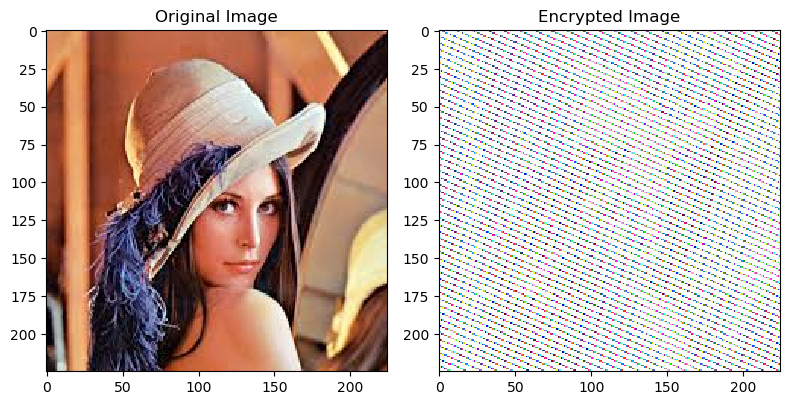

In [13]:
#call this function with input image path to perform encryption
proposeEncryption("SampleImages/1.png")

# proposeEncryption("C:\\Users\\knvbo\\OneDrive\\Pictures\\sc22.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Propose PSNR : 0
Propose SSIM : 1.0


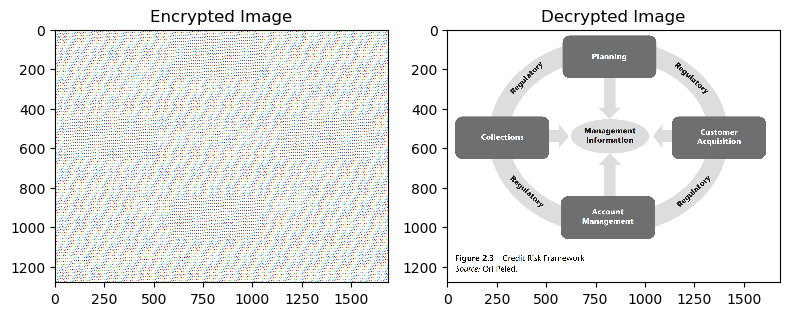

In [12]:
#call this function with encrypted image path to decrypt image
proposeDecryption("EncryptedImages/sc22.png.npy")

In [14]:
data = np.load('keys/1.png.npy')
print(data)

ValueError: Object arrays cannot be loaded when allow_pickle=False